# Heads up!


1.   为你的代码块添加markdown section标识，必要时给注释，这样可以方便的折叠代码块，同时利用目录方便定位， `# title`是一级标题，两个`##`是二级标题，以此类推
2.  

# Download dataset

Berkeley Segmentation Dataset 500 (BSDS500), see google doc dataset section

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")

print("Path to dataset files:", path)

100%|██████████| 56.0M/56.0M [00:00<00:00, 78.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1


[链接文字](https://)Now we have the dataset in our current directory, we check one image below

In [ ]:
! cp -r $path ./berkeley_data

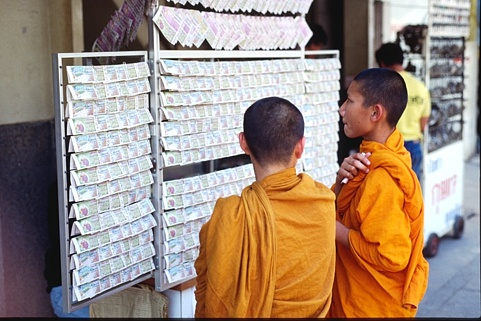

In [ ]:
# prompt: show image "/content/berkeley_data/images/test/100007.jpg"

from IPython.display import Image

image_path = './berkeley_data/images/test/147080.jpg'
# image_path = './berkeley_data/images/test/100007.jpg'
# image_path = './berkeley_data/images/test/107014.jpg'
Image(image_path)

In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


# Global parameter

In [ ]:
cluster_number = 3

# Solution 1 (using threshold)

## Solver: Genetic Algorithm

In [ ]:
import numpy as np
import cv2
import pygad

# Get gray images
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Calculate the histogram and normalization probability of the image
hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
prob = hist / np.sum(hist)

In [ ]:

# define fitness function
def fitness_function(ga_instance, solution, solution_idx):
    # 确保阈值是整数且满足升序约束
    thresholds = sorted(np.round(solution).astype(int))
    thresholds = [0] + thresholds + [255]

    # 计算类间方差 J(T)
    total_mean = np.sum([i * prob[i] for i in range(256)])  # 全局灰度均值
    J = 0
    for k in range(len(thresholds) - 1):
        class_prob = np.sum(prob[thresholds[k]:thresholds[k + 1]])
        if class_prob > 0:
            class_mean = np.sum([i * prob[i] for i in range(thresholds[k], thresholds[k + 1])]) / class_prob
            J += class_prob * (class_mean - total_mean) ** 2

    return J

GA running time: 0.8527 seconds


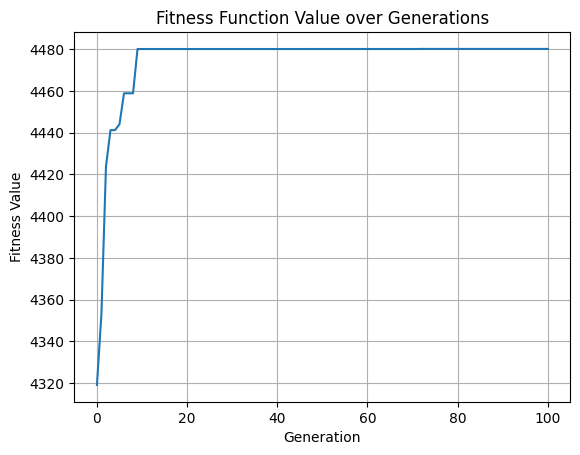

In [ ]:
import time
# 设置遗传算法参数
num_classes = cluster_number  # 目标分割成的类别数
num_thresholds = num_classes - 1  # 阈值数量
gene_space = {'low': 0, 'high': 255}

ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_thresholds,
    gene_space=gene_space
)
# 记录开始时间
start_time = time.time()

# 运行遗传算法
ga_instance.run()


# 记录结束时间
end_time = time.time()

# 计算运行时间
running_time = end_time - start_time

# 输出运行时间
print(f"GA running time: {running_time:.4f} seconds")

fitness_values = ga_instance.best_solutions_fitness

# Create the plot
plt.plot(fitness_values)
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Fitness Function Value over Generations")
plt.grid(True)
plt.show()


In [ ]:


# 获取最优阈值
solution, solution_fitness, _ = ga_instance.best_solution()
optimal_thresholds = sorted(np.round(solution).astype(int))

print("Optimal Thresholds:", optimal_thresholds)
print("Solution Fitness:", solution_fitness)

import cv2
from matplotlib import cm

# 定义函数生成差异最大的颜色
def generate_distinct_colors(num_classes):
    # 使用 matplotlib 的 colormap (例如 'tab10', 'viridis', 'plasma') 生成颜色
    colormap = cm.get_cmap('tab10', num_classes)  # 'tab10' 非常适合分类任务
    colors = [tuple((np.array(colormap(i)[:3]) * 255).astype(int)) for i in range(num_classes)]
    return colors

# 根据 num_classes 生成颜色
colors = generate_distinct_colors(num_classes)

# 确保 colors 的长度等于 num_classes
assert len(colors) == num_classes

# 打印生成的颜色（调试用，可注释掉）
print(f"Generated colors for {num_classes} classes: {colors}")

# 将图像按最优阈值分割为RGB
segmented_image_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

thresholds = [0] + optimal_thresholds + [255]
for k in range(len(thresholds) - 1):
    # 为每个分割区域赋予对应的颜色
    mask = (image >= thresholds[k]) & (image < thresholds[k + 1])
    segmented_image_rgb[mask] = colors[k]

# 保存分割后的RGB图像
cv2.imwrite('segmented_image_rgb.png', segmented_image_rgb)

Optimal Thresholds: [96, 180]
Solution Fitness: 4480.056485299228
Generated colors for 3 classes: [(31, 119, 180), (140, 86, 75), (23, 190, 207)]


<ipython-input-258-b8d9213ecb64>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_classes)  # 'tab10' 非常适合分类任务


True

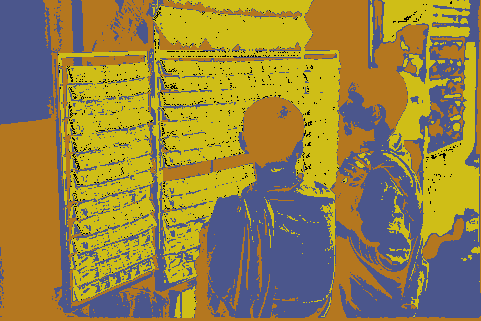

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(segmented_image_rgb)


In [ ]:
solution

array([ 96.04258998, 179.85875046])

In [ ]:
solution_fitness

4480.056485299228

## Solver: 1-st order gradient descent

GA running time: 0.0433 seconds
Final thresholds: [0, 91, 176, 255]


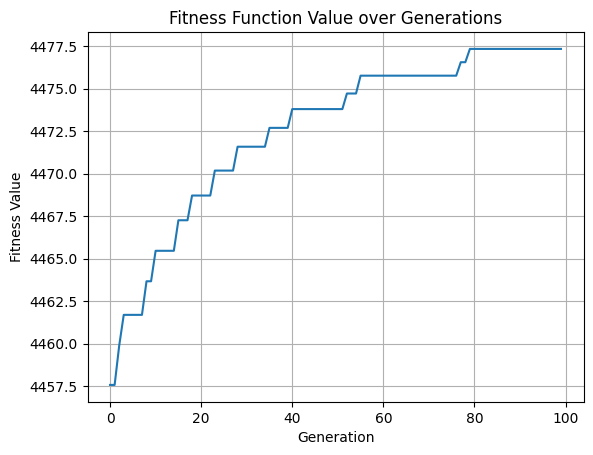

In [ ]:
import numpy as np
import cv2

# 读取灰度图像并计算直方图
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
prob = hist / np.sum(hist)

# 初始化参数
num_classes = cluster_number  # 类别数量
thresholds = np.linspace(0, 255, num_classes + 1)[1:-1]  # 初始阈值均匀分布
max_iterations = 100  # 最大迭代次数
epsilon = 1e-3  # 收敛条件

# 全局灰度均值
total_mean = np.sum([i * prob[i] for i in range(256)])

def compute_class_params(start, end):
    """计算某类的概率和均值"""
    start, end = int(start), int(end)  # 确保范围是整数
    P_k = np.sum(prob[start:end])
    if P_k > 0:
        mu_k = np.sum([i * prob[i] for i in range(start, end)]) / P_k
    else:
        mu_k = 0
    return P_k, mu_k

def compute_gradient(thresholds, k, prob):
    """计算 J 对 T_k 的导数"""
    T_k_prev = 0 if k == 0 else thresholds[k - 1]
    T_k_next = 255 if k == len(thresholds) - 1 else thresholds[k + 1]
    T_k = thresholds[k]

    P_k, mu_k = compute_class_params(T_k_prev, T_k)
    P_k_next, mu_k_next = compute_class_params(T_k, T_k_next)

    # 类间方差的梯度贡献
    gradient = 0

    # P_k 对 T_k 的导数
    if P_k > 0:
        gradient += 2 * P_k * (mu_k - total_mean) * prob[int(T_k)] * (T_k - mu_k) / P_k

    # P_k_next 对 T_k 的导数
    if P_k_next > 0:
        gradient += 2 * P_k_next * (mu_k_next - total_mean) * prob[int(T_k)] * (mu_k_next - T_k) / P_k_next

    # 距离部分的直接差值
    gradient += prob[int(T_k)] * ((mu_k - total_mean) ** 2 - (mu_k_next - total_mean) ** 2)

    # # P_k 对 T_k 的导数
    # if P_k > 0:
    #     gradient += 2 * P_k * (mu_k - total_mean) * (P_k + mu_k * P_k) / P_k

    # # P_k_next 对 T_k 的导数
    # if P_k_next > 0:
    #     gradient += 2 * P_k_next * (mu_k_next - total_mean) * (P_k_next + mu_k_next * P_k_next) / P_k_next

    # # 距离部分的直接差值
    # gradient += prob[int(T_k)] * ((mu_k_next - total_mean) ** 2 - (mu_k - total_mean) ** 2)

    return -gradient

objective_value_history = []

# 记录开始时间
start_time = time.time()

# 梯度下降优化
for iteration in range(max_iterations):
    prev_thresholds = thresholds.copy()

    for k in range(len(thresholds)):
        T_k_prev = 0 if k == 0 else thresholds[k - 1]
        T_k_next = 255 if k == len(thresholds) - 1 else thresholds[k + 1]

        # 计算梯度
        gradient = compute_gradient(thresholds, k, prob)

        # 梯度更新 (学习率可以调整)
        learning_rate = 0.1
        thresholds[k] -= learning_rate * gradient

        # 确保阈值在合法范围内
        thresholds[k] = np.clip(thresholds[k], T_k_prev + 1, T_k_next - 1)

    objective_value_history.append(fitness_function(None, thresholds, None))

    # 检查收敛条件
    if np.max(np.abs(thresholds - prev_thresholds)) < epsilon:
        print(f"Converged at iteration {iteration + 1}")
        break


# 记录结束时间
end_time = time.time()

# 计算运行时间
running_time = end_time - start_time

# 输出运行时间
print(f"GA running time: {running_time:.4f} seconds")

# 打印最终阈值
thresholds = [int(t) for t in thresholds]  # 转为整数
thresholds = [0] + thresholds + [255]

print("Final thresholds:", thresholds)


# Create the plot
plt.plot(objective_value_history)
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Fitness Function Value over Generations")
plt.grid(True)
plt.show()

# # 将图像按最优阈值分割
# segmented_image = np.zeros_like(image)
# thresholds = [0] + thresholds + [255]
# for k in range(len(thresholds) - 1):
#     segmented_image[(image >= thresholds[k]) & (image < thresholds[k + 1])] = (k + 1) * (255 // num_classes)

# 保存分割结果
# cv2.imwrite('segmented_image.png', segmented_image)

In [ ]:
fitness_function(None, thresholds, None)

4475.767021313715

<ipython-input-258-b8d9213ecb64>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_classes)  # 'tab10' 非常适合分类任务


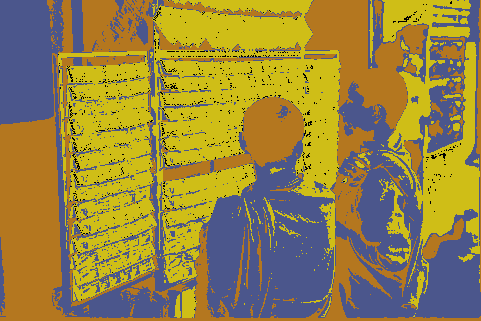

In [ ]:
# 根据 num_classes 生成颜色
colors = generate_distinct_colors(num_classes)

# 确保 colors 的长度等于 num_classes
assert len(colors) == num_classes

# 打印生成的颜色（调试用，可注释掉）
# print(f"Generated colors for {num_classes} classes: {colors}")

# 将图像按最优阈值分割为RGB
segmented_image_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

for k in range(len(thresholds) - 1):
    # 为每个分割区域赋予对应的颜色
    mask = (image >= thresholds[k]) & (image < thresholds[k + 1])
    segmented_image_rgb[mask] = colors[k]

cv2_imshow(segmented_image_rgb)

# Solution 2 (using similarity)

## Solver: Alternating Optimization

In [ ]:
  !pip install ipdb


In [ ]:
import ipdb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def initialize_clusters(image, K):
    """初始化聚类中心"""
    H, W = image.shape
    pixel_values = image.flatten()
    cluster_centers = np.random.choice(pixel_values, K, replace=False)
    cluster_positions = np.random.randint(0, min(H, W), (K, 2))
    return cluster_centers, cluster_positions

def assign_clusters(image, cluster_centers, cluster_positions, alpha, beta, gamma=1.5):
    """分配像素到最近的聚类"""
    H, W = image.shape
    pixel_values = image.flatten()
    indices = np.indices((H, W)).reshape(2, -1).T  # 每个像素的坐标
    distances = np.zeros((len(pixel_values), len(cluster_centers)))

    for k in range(len(cluster_centers)):
        # 计算距离矩阵
        color_distance = alpha * (pixel_values - cluster_centers[k])**2
        spatial_distance = beta * (np.sum((indices - cluster_positions[k])**2, axis=1) ** gamma)
        distances[:, k] = color_distance + spatial_distance

    # 分配每个像素到最近的类
    labels = np.argmin(distances, axis=1)
    return labels.reshape(H, W)

def update_cluster_centers(image, labels, K):
    """更新每个聚类的灰度中心"""
    cluster_centers = np.zeros(K)
    for k in range(K):
        pixels_in_cluster = image[labels == k]
        if len(pixels_in_cluster) > 0:
            cluster_centers[k] = np.mean(pixels_in_cluster)
    return cluster_centers

def update_cluster_positions(labels, K, old_cluster_positions, gamma=1.5):
    """更新每个聚类的空间中心"""
    cluster_positions = []
    H, W = labels.shape
    indices = np.indices((H, W)).reshape(2, -1).T

    for k in range(K):
        positions_in_cluster = indices[labels.flatten() == k]
        if len(positions_in_cluster) > 0:
            '''使用gamma'''
            # 计算每个像素点到当前聚类中心的距离 d_ik
            distances = np.sum((positions_in_cluster - old_cluster_positions[k]) ** 2, axis=1) # ;ipdb.set_trace()

            # 对距离进行 gamma 次幂加权
            weights = (distances) ** (gamma - 1)

            # 更新聚类中心的坐标，采用加权平均
            weighted_sum = np.sum(weights[:, np.newaxis] * positions_in_cluster, axis=0)
            total_weight = np.sum(weights)

            if total_weight > 0:
                cluster_center = weighted_sum / total_weight
            else:
                # 如果没有像素属于该类，选择中心点
                cluster_center = np.array([H // 2, W // 2])

            cluster_positions.append(cluster_center)

            '''不使用gamma'''
            # cluster_center = np.mean(positions_in_cluster, axis=0)
            # cluster_positions.append(cluster_center)
        else:
            cluster_positions.append([H // 2, W // 2])  # 如果没有像素属于该类，随机选择一个位置

    return np.array(cluster_positions)

def similarity_segmentation(image, K, alpha, beta, max_iterations=100, tol=1e-4, gamma=1.0):
    """基于相似性的图像分割"""
    H, W = image.shape
    cluster_centers, cluster_positions = initialize_clusters(image, K)
    labels = np.zeros((H, W), dtype=int)
    prev_J = float('inf')

    J_histroy = []

    # 记录开始时间
    start_time = time.time()

    for iteration in range(max_iterations):
        # 分配像素到最近的类
        labels = assign_clusters(image, cluster_centers, cluster_positions, alpha, beta, gamma=gamma)

        # 更新每个类的灰度中心
        cluster_centers = update_cluster_centers(image, labels, K)

        # 更新每个类的空间位置
        cluster_positions = update_cluster_positions(labels, K, cluster_positions, gamma=gamma)

        # 计算当前的目标函数值
        J = 0
        indices = np.indices((H, W)).reshape(2, -1).T
        for k in range(K):
            pixels_in_cluster = image[labels == k]
            if len(pixels_in_cluster) > 0:
                color_distance = alpha * np.sum((pixels_in_cluster - cluster_centers[k])**2)
                spatial_distance = beta * np.sum(
                    np.sum((indices[labels.flatten() == k] - cluster_positions[k])**2, axis=1) ** gamma
                    )
                J += color_distance + spatial_distance

        print(f"Iteration {iteration + 1}: J = {J}")
        J_histroy.append(J)

        # 检查是否收敛
        if abs(prev_J - J) < tol:
            print("Converged!")
            break
        prev_J = J


    # 记录结束时间
    end_time = time.time()

    # 计算运行时间
    running_time = end_time - start_time

    # 输出运行时间
    print(f"GA running time: {running_time:.4f} seconds")

    return labels, cluster_centers, cluster_positions, J_histroy

Iteration 1: J = 1749889247.7418675
Iteration 2: J = 1514455257.0875754
Iteration 3: J = 1406199495.101943
Iteration 4: J = 1376942450.1524134
Iteration 5: J = 1369488983.0313358
Iteration 6: J = 1367654591.1694808
Iteration 7: J = 1367233512.5106387
Iteration 8: J = 1367144149.7951357
Iteration 9: J = 1367127770.7329407
Iteration 10: J = 1367124475.1922703
Iteration 11: J = 1367123880.8290153
Iteration 12: J = 1367123779.1583207
Iteration 13: J = 1367123770.2434094
Iteration 14: J = 1367123768.9440298
Iteration 15: J = 1367123768.9440298
Converged!
GA running time: 0.8855 seconds


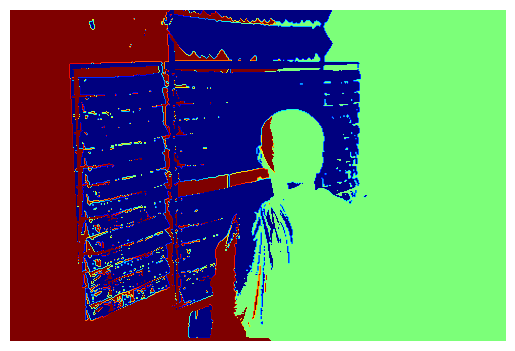

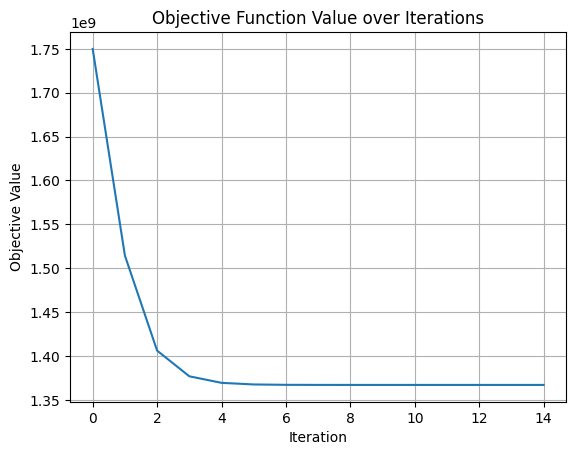

In [ ]:
labels, cluster_centers, cluster_positions, J_histroy = similarity_segmentation(image, K=cluster_number, alpha=1.0, beta=0.5, gamma=1.0)
plt.imshow(labels, cmap='jet')
plt.axis('off')
plt.show()

# Create the plot
plt.plot(J_histroy)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Objective Function Value over Iterations")
plt.grid(True)
plt.show()

## Solver: Genetic Algorithm (deprecated)

In [ ]:
# import numpy as np
# import pygad

# # 初始化参数
# alpha = 1.0  # 颜色权重
# beta = 0.5   # 空间权重
# K = 3        # 类别数

# def initialize_data(image):
#     """初始化像素值和坐标"""
#     H, W = image.shape
#     pixel_values = image.flatten()  # 将图像展平成一维数组
#     indices = np.indices((H, W)).reshape(2, -1).T  # 每个像素的二维坐标
#     return pixel_values, indices, H, W

# def fitness_function(ga_instance, solution, solution_idx):
#     """
#     适应度函数，用于评估每个解的质量。
#     solution: 每个解表示每个像素的类别分配，长度为 N (像素数量)。
#     """
#     global pixel_values, indices, alpha, beta, K

#     # 将 solution 转化为每个像素的类别
#     labels = solution.astype(int)

#     # 计算每个类别的颜色中心 (mu_k) 和空间中心 (pk)
#     mu_k = []
#     pk = []
#     for k in range(K):
#         pixels_in_cluster = pixel_values[labels == k]
#         coordinates_in_cluster = indices[labels == k]
#         if len(pixels_in_cluster) > 0:
#             mu_k.append(np.mean(pixels_in_cluster))  # 颜色中心
#             pk.append(np.mean(coordinates_in_cluster, axis=0))  # 空间中心
#         else:
#             # 如果该类别没有像素，随机初始化
#             mu_k.append(0)
#             pk.append([0, 0])
#     mu_k = np.array(mu_k)
#     pk = np.array(pk)

#     # 计算目标函数 J
#     J = 0
#     for k in range(K):
#         pixels_in_cluster = pixel_values[labels == k]
#         coordinates_in_cluster = indices[labels == k]
#         if len(pixels_in_cluster) > 0:
#             J += alpha * np.sum((pixels_in_cluster - mu_k[k])**2)  # 颜色一致性
#             J += beta * np.sum(np.sum((coordinates_in_cluster - pk[k])**2, axis=1))  # 空间一致性

#     # 遗传算法需要最大化适应度，因此返回负的 J
#     return -J

# def run_genetic_algorithm(image, num_generations=50, sol_per_pop=10, K=3):
#     """
#     使用遗传算法优化目标函数
#     """
#     global pixel_values, indices, H, W
#     pixel_values, indices, H, W = initialize_data(image)

#     # 定义基因空间：为每个像素指定类别范围 [0, K-1]
#     gene_space = range(K)

#     # 初始化遗传算法
#     ga_instance = pygad.GA(
#         num_generations=num_generations,  # 迭代次数
#         num_parents_mating=4,             # 参与交配的父代数量
#         fitness_func=fitness_function,   # 适应度函数
#         sol_per_pop=sol_per_pop,         # 每代种群大小
#         num_genes=len(pixel_values),     # 基因数量 = 像素数量
#         gene_space=gene_space,           # 动态定义基因取值范围
#         mutation_percent_genes=10        # 10% 的基因会发生变异
#     )

#     # 开始运行遗传算法
#     ga_instance.run()

#     # 提取最优解
#     solution, solution_fitness, solution_idx = ga_instance.best_solution()
#     print(f"Best solution fitness: {-solution_fitness}")

#     # 返回分配标签
#     labels = solution.astype(int).reshape(H, W)
#     return labels

# # 示例运行
# if __name__ == "__main__":
#     # 创建示例图像
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#     # 运行遗传算法
#     labels = run_genetic_algorithm(image, num_generations=50, sol_per_pop=50, K=K)

#     # 可视化结果
#     import matplotlib.pyplot as plt
#     plt.imshow(labels, cmap='viridis')
#     plt.title("Segmented Image")
#     plt.show()

In [ ]:
labels

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1]])